# Life Expectancy
## Machine learning Project

Life expectancy is a statistical measure of the estimate of the span of a life. The most commonly used measure is life expectancy at birth which is the definition to be used in this project.


### Aims

The aim of this project is to identify some of the key contributing factors to a countries life expectancy figures and to build and evaluate a machine learning model that attempts to predict a countries life expectancy score given a number of predictor variables.


### Data Preparation and Cleaning

Predictor variables have been chosen that are anticipated to have an impact on a countries life expectancy. Chosing variables that have historic data available greatly increases the source data set that can be worked on. This way Germany in 2001 and Germany in 2017 can be considered separate cases. To build the training data set all countries data between 1980 and 2021 will be used where available.

Data for both life expecatnacy and the predictor variables is sourced from the World Bank and the WHO, full links can be found at the end of this report. Both the World Bank and the WHO are credible, reputable organisations and their data can be trusted to be as accurate as reasonable practicable. 

Where there are gaps in the data gathered, linear interpolation is to be used to fill out the data sets to allow for a larger training set or the machine learning model.

In [1]:
# importing packages to be used in this project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

import pickle

In [2]:
'''Countries

Data from the World Bank is frequently measured for all countries and aggregated across an number of country groupings (e.g. South America, Sub Saharan Africa etc.)
This aggregated data is not useful for building the model and is removed'''

country_list_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Country List\Country List.csv")
country_list = country_list_raw.drop(country_list_raw.index[217:266], axis=0)
#country_list


In [3]:
'''Life Expectancy - Target Variable'''

life_expectancy_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Life Expectancy\Life Expectancy.csv", on_bad_lines='skip')
#life_expectancy_raw
# Removing redundant columns and pre 1980 dates and 2022
life_expectancy = life_expectancy_raw.drop(life_expectancy_raw.columns[1:24], axis=1)
life_expectancy = life_expectancy.drop(life_expectancy.columns[-1], axis=1)
#life_expectancy


In [4]:
#life_expectancy.describe()

In [5]:
life_expectancy_unpivot = life_expectancy.melt(id_vars = "Country Name", var_name = "Year", value_name = "Life Expectancy").sort_values(["Country Name", "Year"], ascending=[True, True])
#life_expectancy_unpivot

# Unpivoting the data allows for easier joining to other data soures and allows for each country to be represented multiple times across a number of years.

Other Predictor variables to now be brought in and reshaped in a similar manner to match Life Expectancy. Interpolation is to be used where necessary to further fill out the data set.

In [6]:
'''Population'''
population_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Population\Population.csv")
#population_raw
population = population_raw.drop(population_raw.columns[1:24], axis=1)
population = population.drop(population.columns[-1], axis=1)
#population

In [7]:
population_unpivot = population.melt(id_vars = "Country Name", var_name = "Year", value_name = "Population").sort_values(["Country Name", "Year"], ascending=[True, True])
#population_unpivot

In [8]:
'''GDP (Gross Domestic Product US$)'''
gdp_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\GDP\GDP.csv")
#gdp_raw
gdp = gdp_raw.drop(gdp_raw.columns[3:24], axis=1)
gdp = gdp.drop(["Series Name", "Series Code", "2022 [YR2022]"], axis=1)
#gdp

In [9]:
gdp_int = gdp.iloc[:,1:43].interpolate(method = 'linear', axis = 1, limit = 3, limit_direction = "both")
gdp_int["Country Name"] = gdp["Country Name"]
#gdp_int

In [10]:
gdp_unpivot = gdp_int.melt(id_vars = "Country Name", var_name = "Year", value_name = "GDP").sort_values(["Country Name", "Year"], ascending=[True, True])
#gdp_unpivot

In [11]:
# Removing excess characters in column values
gdp_unpivot["Year"] = gdp_unpivot["Year"].str[:4] 
#gdp_unpivot.head(10)

In [12]:
'''Gini Index - A measure of income inequality %. 0% is perfectly even wealth distribution, 100% is perfectly uneven.'''
gini_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Gini Index\Gini.csv")
#gini_raw
gini = gini_raw.drop(gini_raw.columns[1:24], axis=1)
gini = gini.drop(["2022"], axis=1)
#gini


In [13]:
gini_int = gini.iloc[:,1:43].interpolate(method = 'linear', axis = 1, limit = 3, limit_direction = "both")
gini_int["Country Name"] = gini["Country Name"]
#gini_int

#gini.describe()
# Most countries do not have this measure available even in years of most coverage. Removing this from the final models may free up additional years of data and improve the model 

In [14]:
gini_unpivot = gini_int.melt(id_vars = "Country Name", var_name = "Year", value_name = "Gini Index").sort_values(["Country Name", "Year"], ascending=[True, True])
#gini_unpivot

In [15]:
'''Poverty - Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)'''
poverty_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Poverty\Poverty.csv")
#poverty_raw
poverty = poverty_raw.drop(poverty_raw.columns[1:24], axis=1)
poverty = poverty.drop(["2022"], axis=1)
#poverty



In [16]:
poverty_int = poverty.iloc[:,1:43].interpolate(method = 'linear', axis = 1, limit = 3, limit_direction = "both")
poverty_int["Country Name"] = poverty["Country Name"]
#poverty_int



In [17]:
poverty_unpivot = poverty_int.melt(id_vars = "Country Name", var_name = "Year", value_name = "Poverty %").sort_values(["Country Name", "Year"], ascending=[True, True])
#poverty_unpivot

In [18]:
#poverty_unpivot.describe() 
# With Interpolation number of usable values roughly doubles

In [19]:
'''Health Expenditure
Health expenditure per capita in US$'''

health_expenditure_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Health Expenditure\Health Expenditure.csv")
health_expenditure_raw
health_expenditure = health_expenditure_raw[["Location", "Period", "Value"]]
health_expenditure = health_expenditure.rename(columns = {"Location": "Country Name", "Period": "Year", "Value":"Health Expenditure"}).sort_values(["Country Name", "Year"], ascending=[True, True])
#health_expenditure

In [20]:
''' Rural Population
Rural population (% of total population)'''
rural_pop_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Rural Pop\Rural Pop.csv")
#rural_pop_raw
rural_pop = rural_pop_raw.drop(rural_pop_raw.columns[1:24], axis=1)
rural_pop = rural_pop.drop(["2022"], axis=1)
#rural_pop



In [21]:
rural_pop_unpivot = rural_pop.melt(id_vars = "Country Name", var_name = "Year", value_name = "Rural Population %").sort_values(["Country Name", "Year"], ascending=[True, True])
#rural_pop_unpivot

In [22]:
'''Literacy Rates
Literacy rate, adult total (% of people ages 15 and above) - a proxy for amount/quality of education in a country'''
literacy_rates_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Literacy Rates\Literacy Rates.csv")
#literacy_rates_raw
literacy_rates = literacy_rates_raw.drop(literacy_rates_raw.columns[1:24], axis=1)
literacy_rates = literacy_rates.drop(["2022"], axis=1)
#literacy_rates

In [23]:
''' Interpolation to fill out intervening years with no data. Giving the eventual model more data to work with. '''

literacy_rates_int = literacy_rates.iloc[:,1:43].interpolate(method = 'linear', axis = 1, limit = 3, limit_direction = "both")
literacy_rates_int["Country Name"] = literacy_rates["Country Name"]
# literacy_rates_int


In [24]:

literacy_rates_unpivot = literacy_rates_int.melt(id_vars = "Country Name", var_name = "Year", value_name = "Literacy Rates %").sort_values(["Country Name", "Year"], ascending=[True, True])
# literacy_rates_unpivot.describe()
# Interpolation more than doubling available data points


In [25]:
'''Infant Mortality - Mortality rate, infant (per 1,000 live births)'''
infant_mortality_raw = pd.read_csv(r"C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project\Raw\Infant Mortality\Infant Mortality.csv")
#infant_mortality_raw
infant_mortality = infant_mortality_raw.drop(infant_mortality_raw.columns[1:24], axis=1)
infant_mortality = infant_mortality.drop(["2022"], axis=1)
#infant_mortality

In [26]:
infant_mortality_int = infant_mortality.iloc[:,1:43].interpolate(method = 'linear', axis = 1, limit = 3, limit_direction = "both")
infant_mortality_int["Country Name"] = infant_mortality["Country Name"]
# infant_mortality_int

In [27]:
infant_mortality_unpivot = infant_mortality_int.melt(id_vars = "Country Name", var_name = "Year", value_name = "Infant Mortality").sort_values(["Country Name", "Year"], ascending=[True, True])
#infant_mortality_unpivot

#### Combining all variables into one DataFrame

In [28]:
#life_expectancy_unpivot
master_df = pd.merge(life_expectancy_unpivot, population_unpivot, how = "left", on = ["Country Name", "Year"])
master_df = pd.merge(master_df, gdp_unpivot , how = "left", on = ["Country Name", "Year"])
master_df = pd.merge(master_df, gini_unpivot , how = "left", on = ["Country Name", "Year"])
master_df = pd.merge(master_df, poverty_unpivot , how = "left", on = ["Country Name", "Year"])
# Data from different source (WHO not World Bank) Year is different data type, changed for merge only.
health_expenditure['Year'] = health_expenditure.Year.astype(object) 
# To be changed to numerical later


## Merging not working as expecte for the WHO data.
## Workaround created below using a joiner proxy 

##Checker
life_expectancy_unpivot["Joiner"] = life_expectancy_unpivot["Country Name"] + life_expectancy_unpivot["Year"]
#life_expectancy_unpivot

health_expenditure["Joiner"] = health_expenditure["Country Name"] + health_expenditure["Year"].astype(str)
#health_expenditure.dtypes

checker_df = life_expectancy_unpivot.merge(health_expenditure, how = "left", on= ['Joiner'])
checker_df = checker_df.drop(columns = ["Joiner", 'Country Name_y', "Year_y", "Life Expectancy"], axis = 1)
checker_df = checker_df.rename(columns = {"Country Name_x":"Country Name", "Year_x":"Year"})
#checker_df


master_df = pd.merge(master_df, checker_df , how = "left", on = ["Country Name", "Year"])
master_df = pd.merge(master_df, rural_pop_unpivot , how = "left", on = ["Country Name", "Year"])
master_df = pd.merge(master_df, literacy_rates_unpivot , how = "left", on = ["Country Name", "Year"])
master_df = pd.merge(master_df, infant_mortality_unpivot , how = "left", on = ["Country Name", "Year"])

#master_df

In [29]:
# Removing country groupings
master_df["Is_Country"]=master_df["Country Name"].isin(country_list["Country Name"])
#master_df

In [30]:

master_df = master_df[master_df.Is_Country==True]

#master_df

In [31]:
# Removing where no target variable is available
master_df = master_df[master_df["Life Expectancy"].notnull()]
#master_df

In [32]:
master_df = master_df.drop(columns = ["Is_Country"], axis = 1)
master_df

,Country Name,Year,Life Expectancy,Population,GDP,Gini Index,Poverty %,Health Expenditure,Rural Population %,Literacy Rates %,Infant Mortality
0,Afghanistan,1980,39.618,12486631.0,3.641723e+09,NaN,NaN,NaN,84.005,NaN,162.6
1,Afghanistan,1981,40.164,11155195.0,3.478788e+09,NaN,NaN,NaN,83.438,NaN,158.3
2,Afghanistan,1982,37.766,10088289.0,3.496666e+09,NaN,NaN,NaN,82.853,NaN,153.9
3,Afghanistan,1983,38.187,9951449.0,3.514545e+09,NaN,NaN,NaN,82.253,NaN,149.6
4,Afghanistan,1984,33.329,10243686.0,3.532423e+09,NaN,NaN,NaN,81.635,NaN,145.5
...,...,...,...,...,...,...,...,...,...,...,...
11167,Zimbabwe,2017,60.709,14751101.0,1.758489e+10,44.3,34.2,92.25,67.763,88.69342,39.5
11168,Zimbabwe,2018,61.414,15052184.0,3.415607e+10,47.3,37.0,114.60,67.791,NaN,38.0
11169,Zimbabwe,2019,61.292,15354608.0,2.183223e+10,50.3,39.8,54.81,67.790,NaN,37.1
11170,Zimbabwe,2020,61.124,15669666.0,2.150970e+10,50.3,39.8,50.68,67.758,NaN,36.6


In [33]:
master_df.describe()

,Life Expectancy,Population,GDP,Gini Index,Poverty %,Health Expenditure,Rural Population %,Literacy Rates %,Infant Mortality
count,8790.000000,8.790000e+03,8.003000e+03,4344.000000,4363.000000,3337.000000,8706.000000,3810.000000,8044.000000
mean,67.755282,2.940587e+07,2.300937e+11,39.131423,17.144408,864.837830,45.534426,78.682242,38.825684
std,9.929903,1.179028e+08,1.121158e+12,8.859968,22.523857,1528.449265,24.357790,21.536172,35.728634
min,12.407000,7.598000e+03,8.824746e+06,20.700000,0.000000,4.450000,0.000000,10.894650,1.600000
25%,61.689250,8.150535e+05,2.611983e+09,32.600000,0.500000,61.430000,26.050000,66.561150,11.300000
50%,70.222500,5.312918e+06,1.204587e+10,37.666667,5.500000,241.800000,46.022500,86.990586,25.650000
75%,74.889000,1.768631e+07,7.589661e+10,44.500000,27.600000,791.500000,65.927250,96.274836,57.800000
max,85.497561,1.412360e+09,2.331508e+13,65.800000,91.500000,10310.000000,95.661000,100.000000,189.900000


The master_df data frame has now be created, cleaned and prepared for use in EDA and machine learning models. There is not complete coverage of data points for all country/year pairs. Where necessary rows with missing data will not be considered for models where this is an issue.


# Additional Exploratory Data Analysis



In [34]:
''' Check Correlation 

Checking correlation between all variables in the master_df data frame. 
Although multicollinearity is not an issue for decision trees or the random forest models that are to be used later
it is intersting to see the interaction between the variables. 
'''

corr_checker = master_df.drop(columns = ["Country Name", "Year"], axis = 1)
#corr_checker.corr(method='pearson')

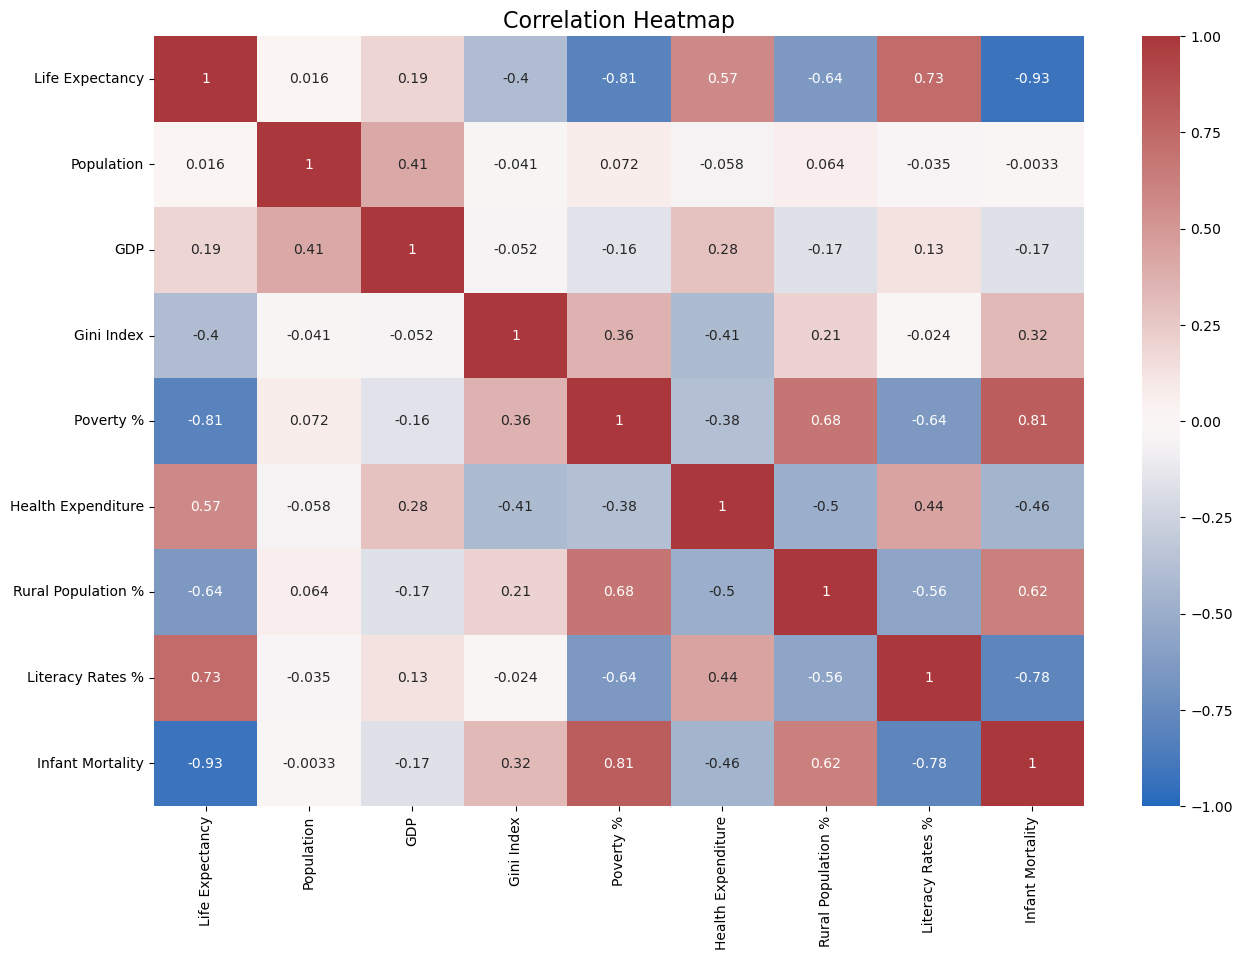

In [35]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_checker.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.title("Correlation Heatmap",
          fontsize=16)
plt.show()

From the correlation heatmap we can see that many of these variables are strongly correlated with Life Expectancy, and some such as Poverty and Infant Mortality are strongly correlated with each other.

C:\Users\jakeo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

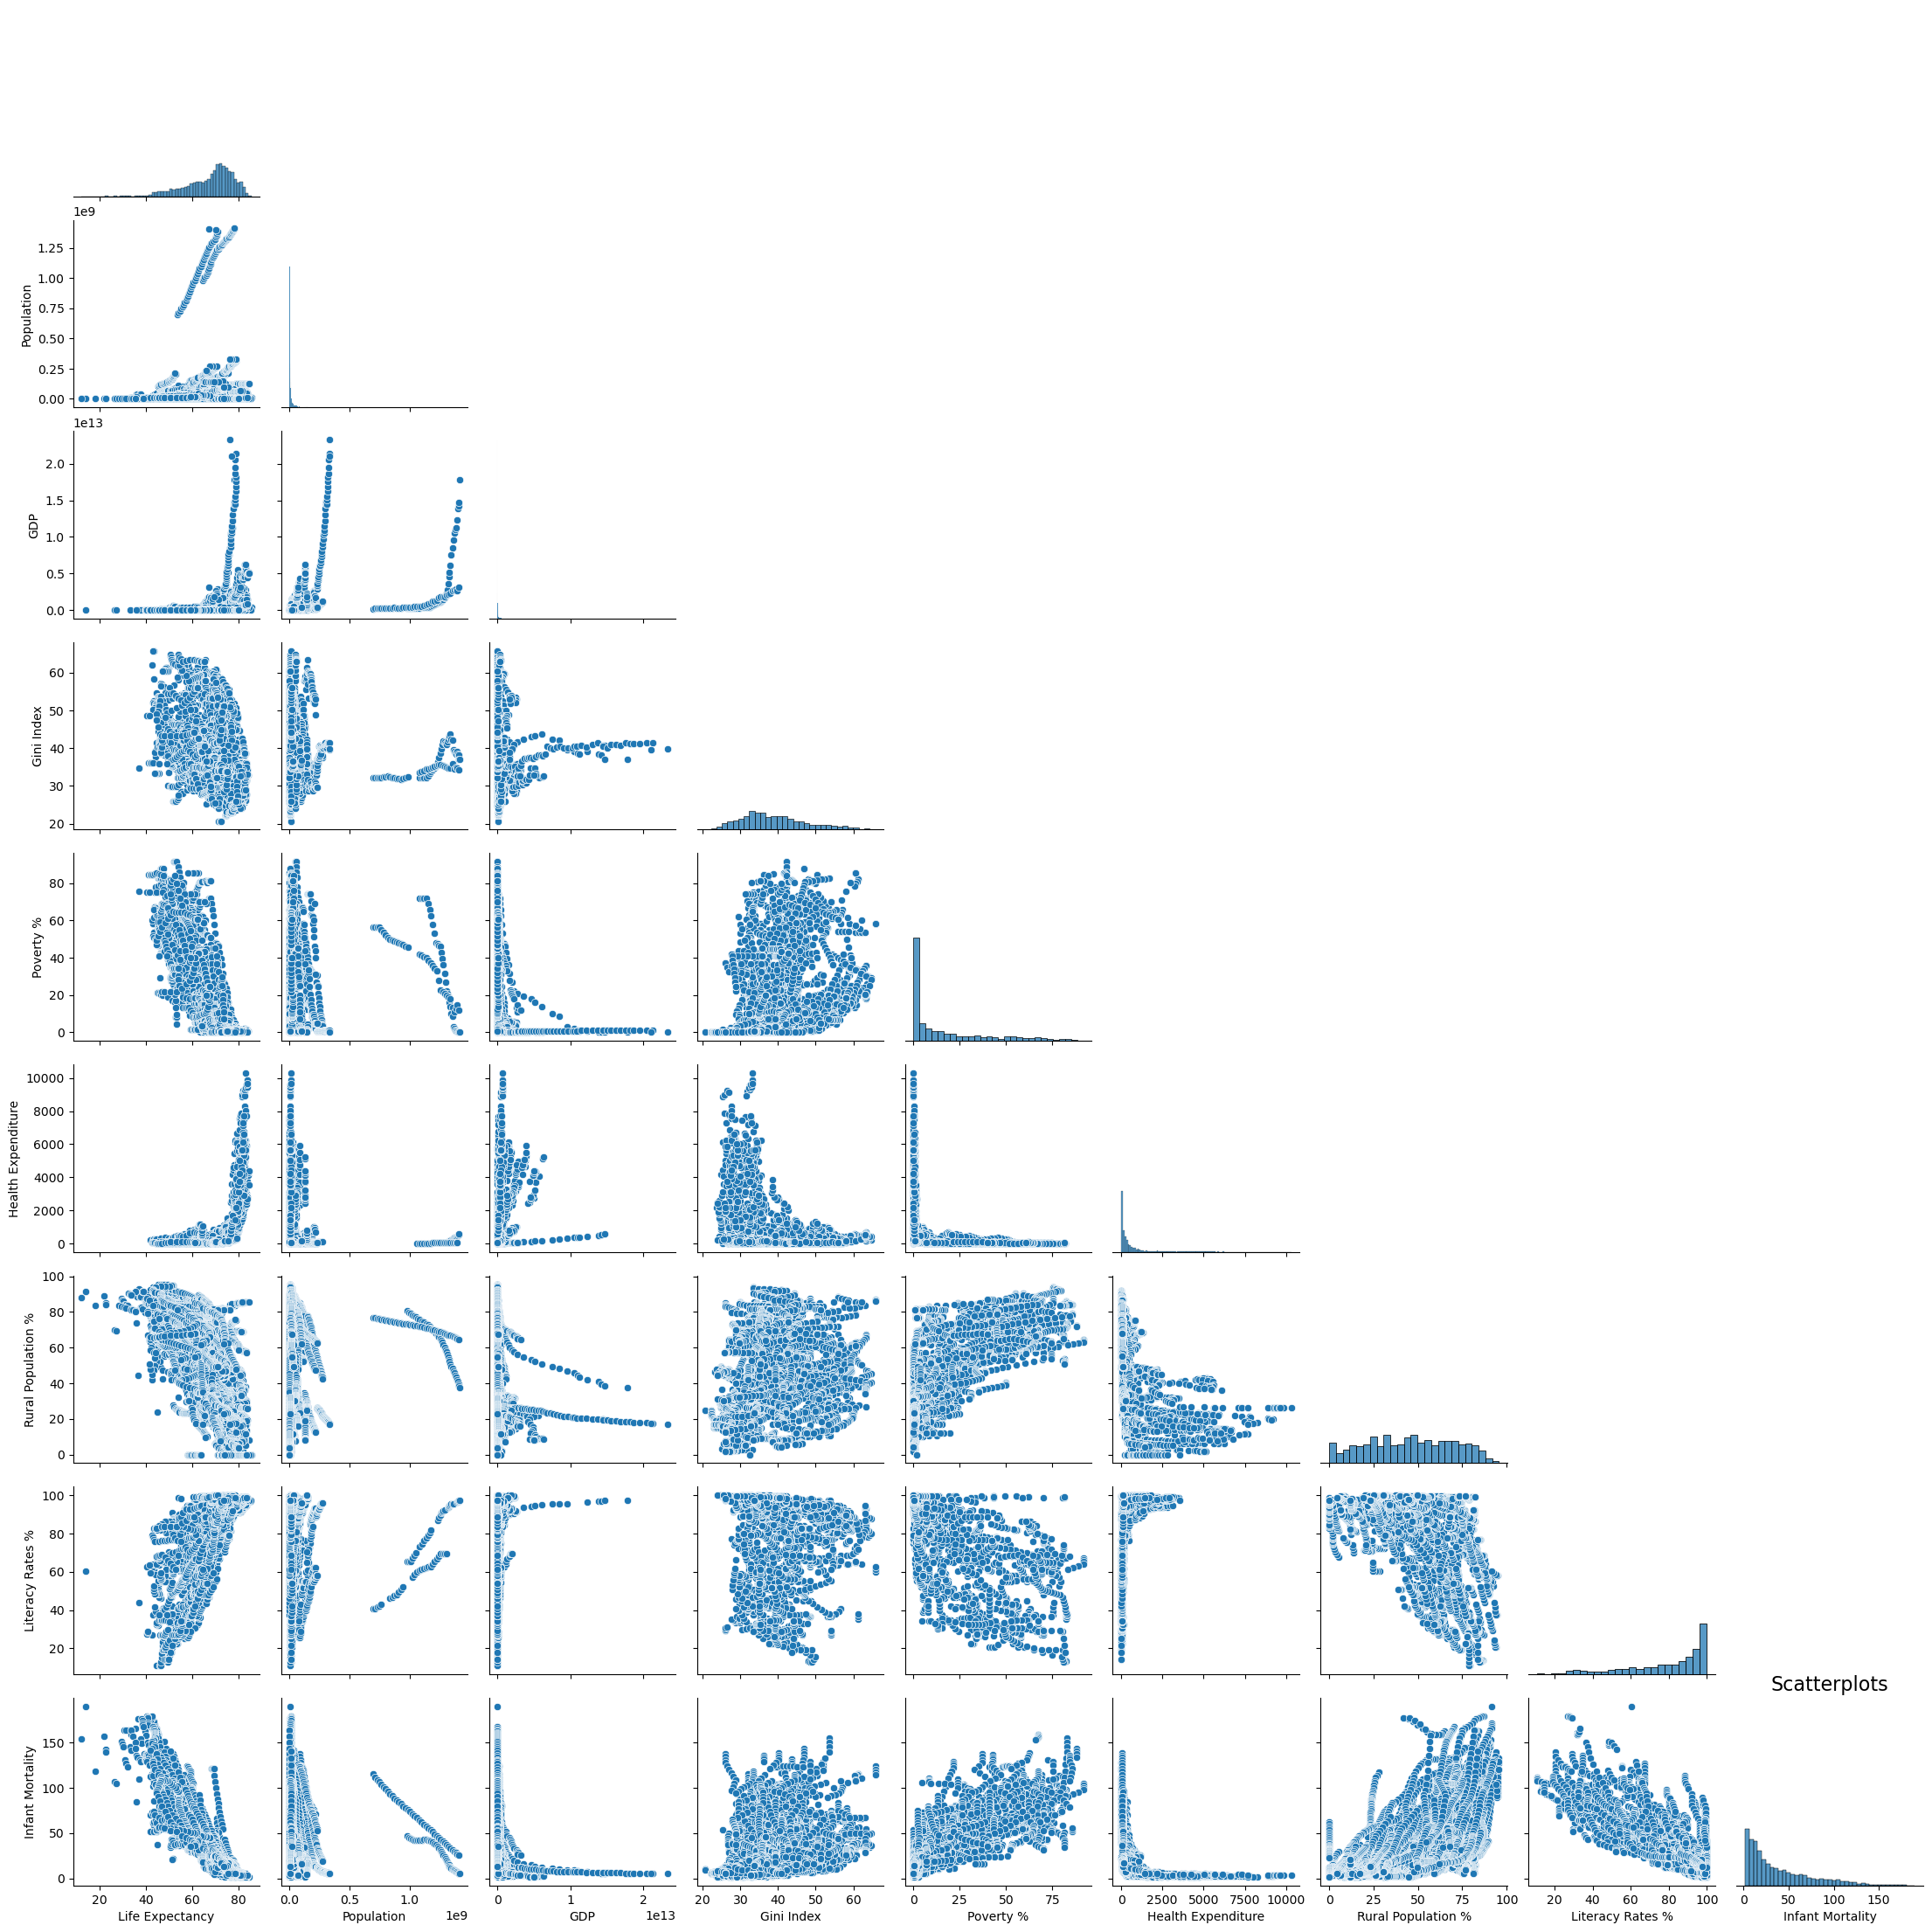

In [36]:
'''The Pairplot function shows scatterplots to complement the correlation heatmap above'''

plt.figure(figsize=(15,10))
sns.pairplot(master_df, corner = True)
plt.title("Scatterplots",
          fontsize=16)
plt.show()

In [37]:
lit_life_scatter = master_df[(master_df['Country Name']=='Mexico') | 
                             (master_df['Country Name']=='Brazil') | 
                             (master_df['Country Name']=='Morocco') |
                             (master_df['Country Name']=='China') |
                             (master_df['Country Name']=='Cambodia') |
                             (master_df['Country Name']=='Moldova')]
lit_life_scatter

,Country Name,Year,Life Expectancy,Population,GDP,Gini Index,Poverty %,Health Expenditure,Rural Population %,Literacy Rates %,Infant Mortality
1218,Brazil,1980,61.781,122288383.0,2.373935e+11,57.9,23.9,NaN,34.532,74.586731,76.6
1219,Brazil,1981,62.333,125168060.0,2.580152e+11,57.9,23.9,NaN,33.630,75.175789,73.6
1220,Brazil,1982,62.856,128065095.0,2.713141e+11,58.4,24.4,NaN,32.738,75.764846,70.6
1221,Brazil,1983,63.331,130977370.0,1.896565e+11,59.0,30.6,NaN,31.858,76.353904,67.9
1222,Brazil,1984,63.773,133888775.0,1.883400e+11,58.4,29.9,NaN,30.990,NaN,65.3
...,...,...,...,...,...,...,...,...,...,...,...
7051,Morocco,2017,73.660,35528115.0,1.185406e+11,NaN,NaN,166.5,38.092,75.586197,18.3
7052,Morocco,2018,73.986,35927511.0,1.273411e+11,NaN,NaN,175.3,37.547,NaN,17.5
7053,Morocco,2019,74.270,36304408.0,1.289203e+11,NaN,NaN,177.3,37.006,NaN,16.7
7054,Morocco,2020,73.920,36688772.0,1.213475e+11,NaN,NaN,187.4,36.468,NaN,16.1


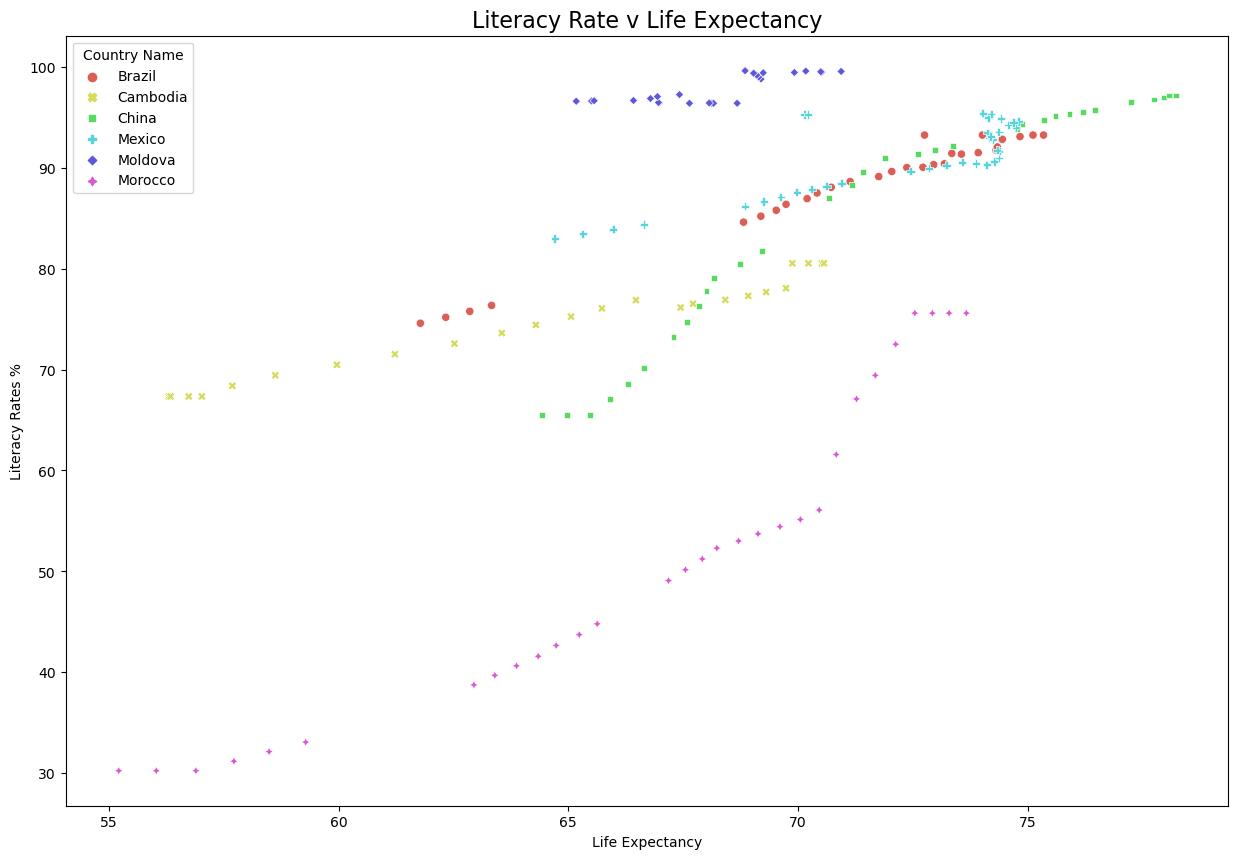

In [38]:
plt.figure(figsize=(15,10))
sns.scatterplot(lit_life_scatter, x="Life Expectancy", y="Literacy Rates %", hue="Country Name", palette = "hls", 
         legend = True, style = "Country Name")
plt.title("Literacy Rate v Life Expectancy",
          fontsize=16)
plt.show()


This scatter graph shows the clear relationship  between the life expectancy and the literacy rates for selected countries. The breakdown for each country demonstrates the tracking of a countries progress in increasing both variables.

## Model Creation

A decision tree and random forest models will be created and contrasted.

A decision tree regression model is an appropriate model for predicting life expectancy as it is a continuous variable and will not require data normalization or dummy variables to be used.

As an aggregation of many decision trees a random forest model is appropriate for the same reasons.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import metrics

In [40]:
# These columns are not relevant predictors
# As can be seen in the correlation heat map, population has been removed as by far the least significant variable.
master_dtr = master_df.drop(columns = ["Country Name", "Year", "Population"], axis = 1)
#master_dtr

In [41]:
# While not strictly necessary to remove rows with missing data while using decision trees this step has been taken.
master_dtr_subset = master_dtr.dropna(axis=0).reset_index(drop = True)
#master_dtr_subset

In [42]:
# Creating the test and training data

y = master_dtr_subset["Life Expectancy"]

X = master_dtr_subset.copy()
X = X.drop("Life Expectancy", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [43]:
decision_tree = DecisionTreeRegressor(max_depth = 5, 
                                      max_leaf_nodes = 50, 
                                      min_samples_leaf = 10, 
                                      random_state=1234)

decision_tree.fit(X_train, y_train)

dt_pred = decision_tree.predict(X_test)
#decision_tree.get_params()

In [44]:
def get_dtscores(model_name:str, model, X_test, y_test):
    ''' Output model scores

    In: 
        model_name-  Model Name
        model-       A fit GridSearchCV object
        X_test-      X_test data
        y_test-      y_test data

    Out: Scores with mean squared error, max error and r2 scores for the model'''

    mean_squared_error = metrics.mean_squared_error(y_test, dt_pred)
    max_error = metrics.max_error(y_test, dt_pred)
    r2 = metrics.r2_score(y_test, dt_pred)
    
    scores = pd.DataFrame({'model': [model_name],
                          'mean squared error': [mean_squared_error], 
                          'max error': [max_error],
                          'r2': [r2]
                         })
  
    return scores

In [45]:
decision_tree_scores = get_dtscores('decision tree', dt_pred, X_test, y_test )
decision_tree_scores

,model,mean squared error,max error,r2
0,decision tree,7.974309,11.168054,0.905577


The metrics used to evaluate the model show quite a high r2 score. This indicates that the model is performing well, although as decision trees are subject to potential overfitting to the data other models with a lower mean squared error should be investigated.

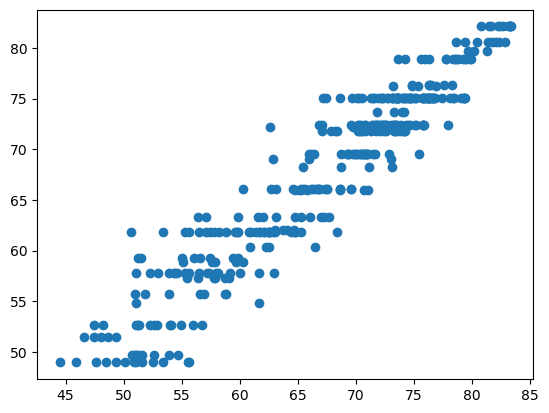

In [46]:
plt.scatter(y_test,dt_pred )

<Axes: xlabel='Life Expectancy', ylabel='Count'>

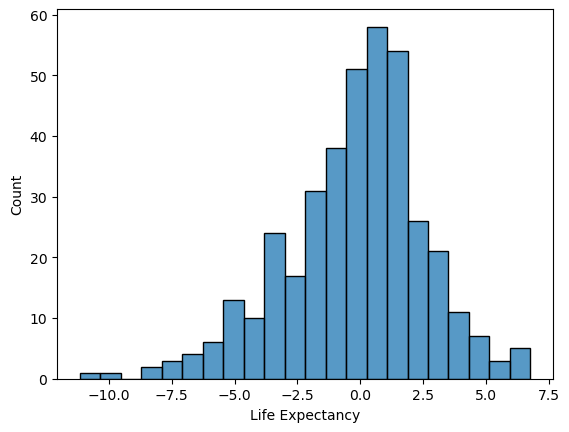

In [47]:
sns.histplot(y_test-dt_pred)

This scatter plot and histogram plot of the error shows that the predicted values are tracking the test values well and that the errors are evenly distributed across the range of values, and normally distributed in terms of the extent of the error.

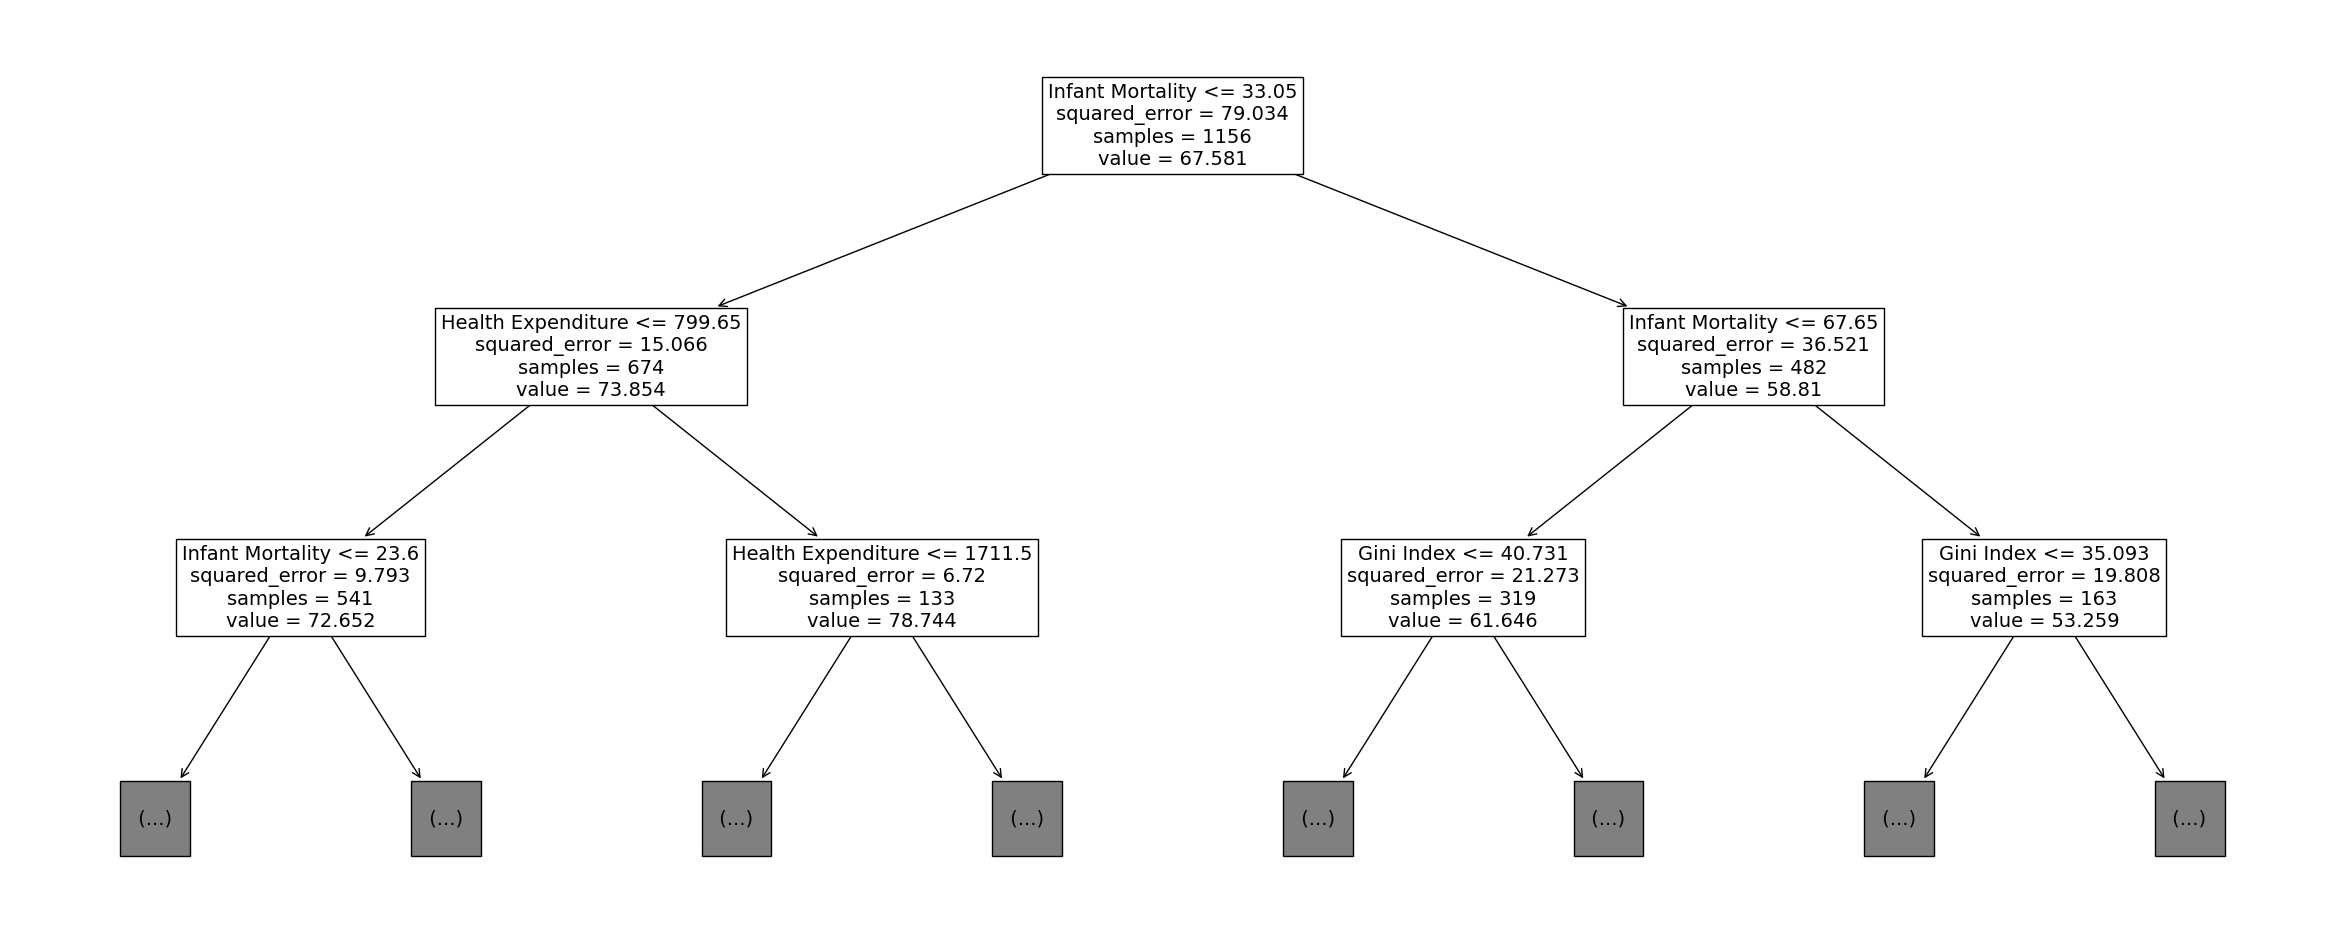

In [48]:
plt.figure(figsize=(30,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns.tolist());

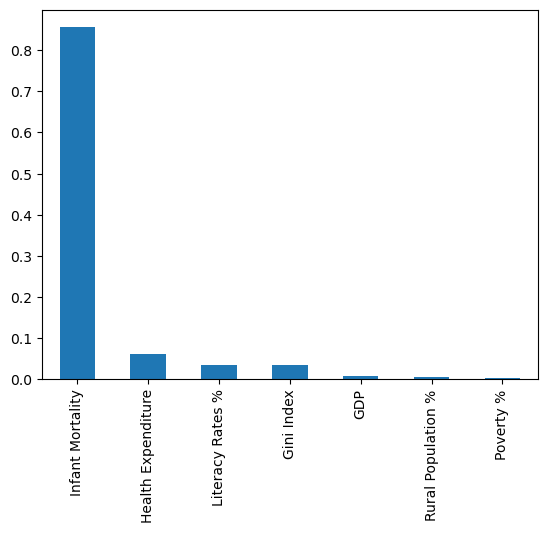

In [49]:
importances = decision_tree.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

The plotting of the first couple of decision tree layers and the feature importance graph show that infant mortality has by far the largest impact on the results of this model. Whilst the impact of GDP, Rural population and Poverty are minimal.

## Hyperparameter Tuning

The decision tree model appear to perform fairly well given the metrics considered. However with hyperparameter tuning this may be improved.

In [50]:
# Setting parameters to test
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,15,20,30,50],
             'min_samples_leaf': [1,2,3,4,5,10,15,20],
           "max_leaf_nodes":[10,20,30,40,50,60,80,100] }

In [51]:
%%time

tuned_decision_tree = DecisionTreeRegressor(random_state=1234)

tuning_model = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring=['neg_mean_squared_error', "r2", "max_error"], 
                   cv=5,
                   refit= "neg_mean_squared_error")
# Model to tune for least mean squared error

tuning_model.fit(X_train, y_train)

CPU times: total: 1min 15s
Wall time: 1min 42s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1234),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20,
                                       30, 50],
                         'max_leaf_nodes': [10, 20, 30, 40, 50, 60, 80, 100],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10, 15, 20]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2', 'max_error'])

In [52]:
#tuning_model.best_params_

In [53]:
# Re-running the model with the tuned parameters
decision_tree_tuned = DecisionTreeRegressor(max_depth=15, 
                                            max_leaf_nodes=100, 
                                            min_samples_leaf=1, 
                                            random_state=1234)

decision_tree_tuned.fit(X_train, y_train)

dt_pred_tuned = decision_tree_tuned.predict(X_test)


In [54]:
def get_dttscores(model_name:str, model, X_test, y_test):
    
        ''' Output tuned model scores

    In: 
        model_name-  Model Name
        model-       A fit GridSearchCV object
        X_test-      X_test data
        y_test-      y_test data

    Out: Scores with mean squared error, max error and r2 scores for the model'''
        mean_squared_error = metrics.mean_squared_error(y_test, dt_pred_tuned)
        max_error = metrics.max_error(y_test, dt_pred_tuned)
        r2 = metrics.r2_score(y_test, dt_pred_tuned)
    
        scores = pd.DataFrame({'model': [model_name],
                          'mean squared error': [mean_squared_error], 
                          'max error': [max_error],
                          'r2': [r2]
                         })
  
        return scores

In [55]:
decision_tree_tuned_scores = get_dttscores('decision tree tuned', dt_pred_tuned, X_test, y_test )
decision_tree_tuned_scores

,model,mean squared error,max error,r2
0,decision tree tuned,4.852321,9.623095,0.942544


With tuned hyperparameters all metrics improved


In [118]:
# Manipulating decision tree outputs for platting
dtrees_plotter = pd.DataFrame({'dt_pred':dt_pred, 'dt_tuned':dt_pred_tuned})
dtrees_plotter["y_test"] = y_test.to_frame().reset_index()["Life Expectancy"]
dtrees_plotter = dtrees_plotter.melt('y_test', var_name='model', value_name='Prediction')
#dtrees_plotter

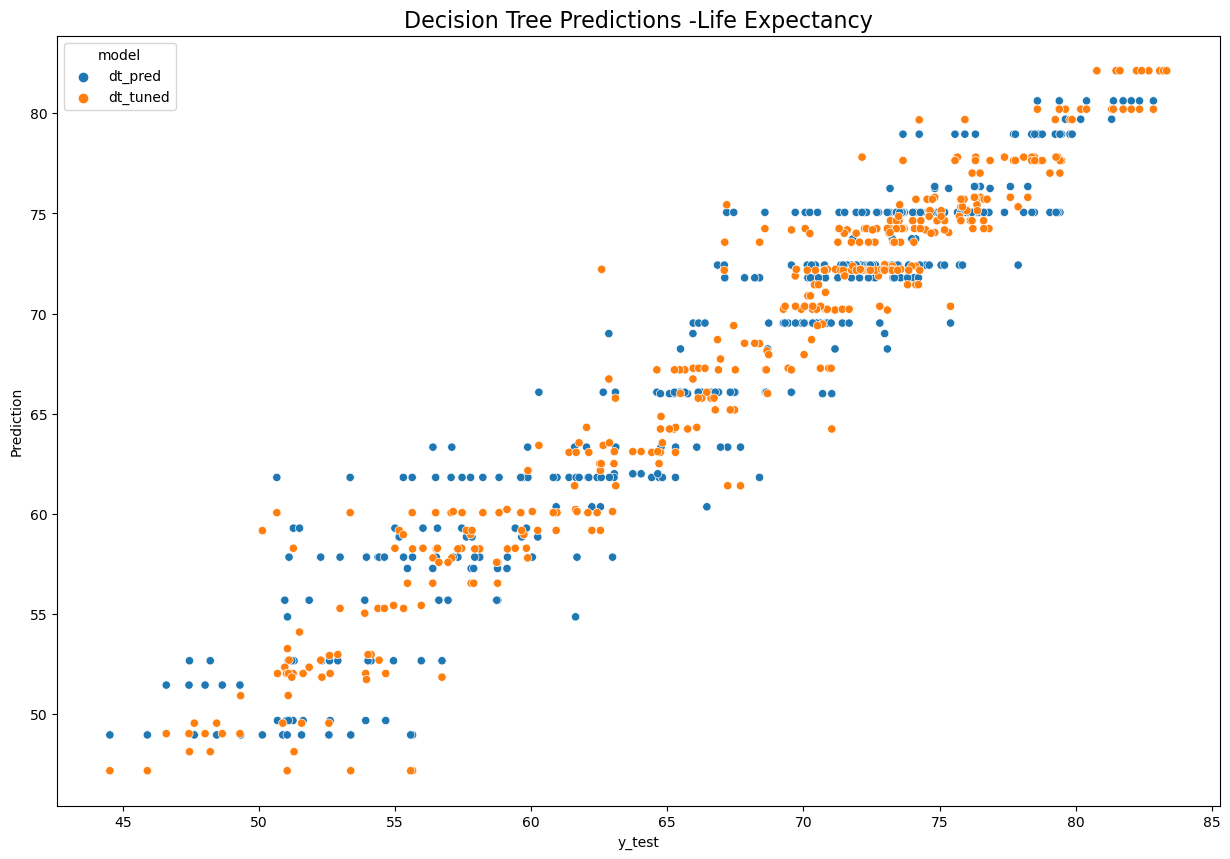

In [58]:
#Plotting Decision Tree and tuned Decision tree predictions v actual life expectancy
plt.figure(figsize=(15,10))
sns.scatterplot(dtrees_plotter, x="y_test", y="Prediction", hue =  "model" )
plt.title("Decision Tree Predictions -Life Expectancy",
          fontsize=16)
plt.show()

This scatter shows the reduction in mean squared error of the tuned model as the predictions more closely align with the test data.

<Axes: xlabel='Life Expectancy', ylabel='Count'>

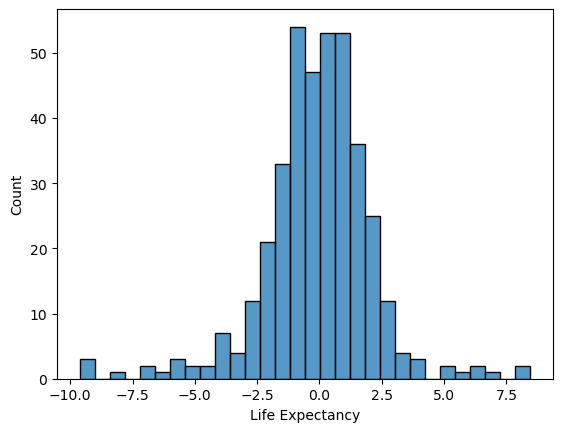

In [59]:
sns.histplot(y_test-dt_pred_tuned)

This histogram for the tuned model shows a normal distribution for the errors.

<Axes: title={'center': 'Importances Comaprison'}>

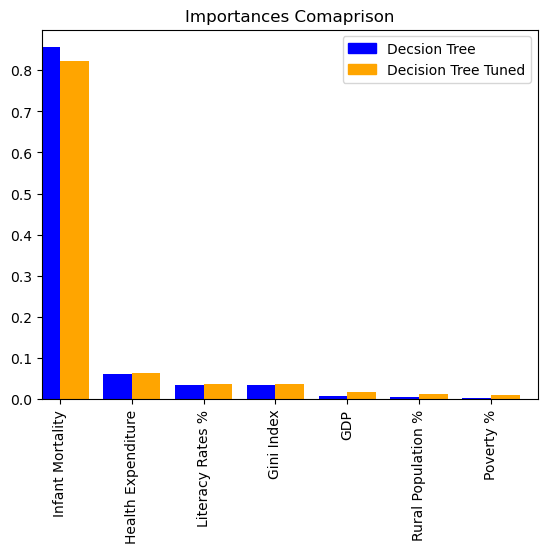

In [63]:
importances_tree = decision_tree.feature_importances_
importances_tuned = decision_tree_tuned.feature_importances_

importances_tree = pd.Series(importances_tree, index=X.columns).sort_values(ascending=False)
importances_tuned = pd.Series(importances_tuned, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
ax.set_title('Importances Comaprison')
colors = {'Decsion Tree':'blue', 'Decision Tree Tuned':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
importances_tree.plot.bar(ax=ax, position = 1, width= 0.4, color ='blue')
importances_tuned.plot.bar(ax=ax, position = 0, width = 0.4, color ='orange')

Here the importances of the two decision tree models can be compared. The tuned model is very similar to the original decision tree, however slightly less importance is placed on Infant Mortality and all other variables increase marginally in importance.

## Random Forest


Creating a random forest model to see if the metrics for Life Expectancy prediction improve

In [64]:
rf = RandomForestRegressor(random_state=1234)

# Assign a dictionary of hyperparameters to search over

rf_cv_params = {'max_depth': [2,5,10], 
             'min_samples_leaf': [2,5,10],
             "max_leaf_nodes":[20,50,100],
             'n_estimators': [100, 250],
                "bootstrap" : [True],
                "random_state" : [1234]
             }  

# Assign a dictionary of scoring metrics to capture
scoring= ['neg_mean_squared_error', "r2", "max_error"]

# Instantiate GridSearch
rf1 = GridSearchCV(rf, rf_cv_params, scoring=scoring, cv=5, refit='r2')

In [79]:
# Output from the grid search to ba saved with pickle due to long run times approx 10 mins

#%%time
#rf1.fit(X_train, y_train) 

CPU times: total: 5min 34s
Wall time: 10min 28s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
             param_grid={'bootstrap': [True], 'max_depth': [2, 5, 10],
                         'max_leaf_nodes': [20, 50, 100],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [100, 250], 'random_state': [1234]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2', 'max_error'])

In [65]:
path = r'C:\Users\jakeo\OneDrive\Documents\Data Analysis\Projects\Life Expectancy Project'

In [81]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [66]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [83]:
# Write pickle
#write_pickle(path, rf1, 'rf1')

In [67]:
# Read pickle
rf1 = read_pickle(path, 'rf1')

In [68]:
#rf1.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 2,
 'n_estimators': 250,
 'random_state': 1234}

In [117]:
#rf1.best_estimator_

In [72]:
def get_rfscores(model_name:str, model, X_test, y_test):
    ''' Output tuned model scores

    In: 
        model_name-  Model Name
        model-       A fit GridSearchCV object
        X_test-      X_test data
        y_test-      y_test data

    Out: Scores with mean squared error, max error and r2 scores for the model'''

    #preds = model.best_estimator_.predict(X_test)

    mean_squared_error = metrics.mean_squared_error(y_test, model.best_estimator_.predict(X_test))
    max_error = metrics.max_error(y_test, model.best_estimator_.predict(X_test))
    r2 = metrics.r2_score(y_test, model.best_estimator_.predict(X_test))
    
    scores = pd.DataFrame({'model': [model_name],
                          'mean squared error': [mean_squared_error], 
                          'max error': [max_error],
                          'r2': [r2]
                         })
  
    return scores

In [73]:
rf1_scores = get_rfscores('random forest 1', rf1, X_test, y_test )
rf1_scores

,model,mean squared error,max error,r2
0,random forest 1,2.929671,9.481615,0.96531


<Axes: xlabel='Life Expectancy', ylabel='Count'>

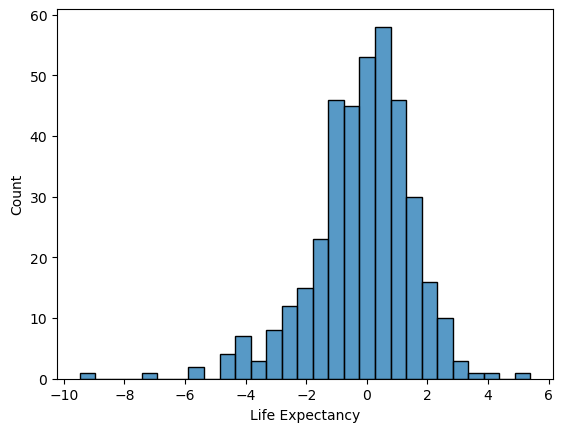

In [116]:
# A normal distribution of the predictions is still seen
sns.histplot(y_test-rf1.best_estimator_.predict(X_test))

In [110]:
# Manipulating decision tree and rf1 outputs for plotting
dtrees_plotter2 = pd.DataFrame({'dt_pred':dt_pred, 'dt_tuned':dt_pred_tuned, "rf":rf1.best_estimator_.predict(X_test)})
dtrees_plotter2["y_test"] = y_test.to_frame().reset_index()["Life Expectancy"]
dtrees_plotter2 = dtrees_plotter2.melt('y_test', var_name='model', value_name='Prediction')
#dtrees_plotter2

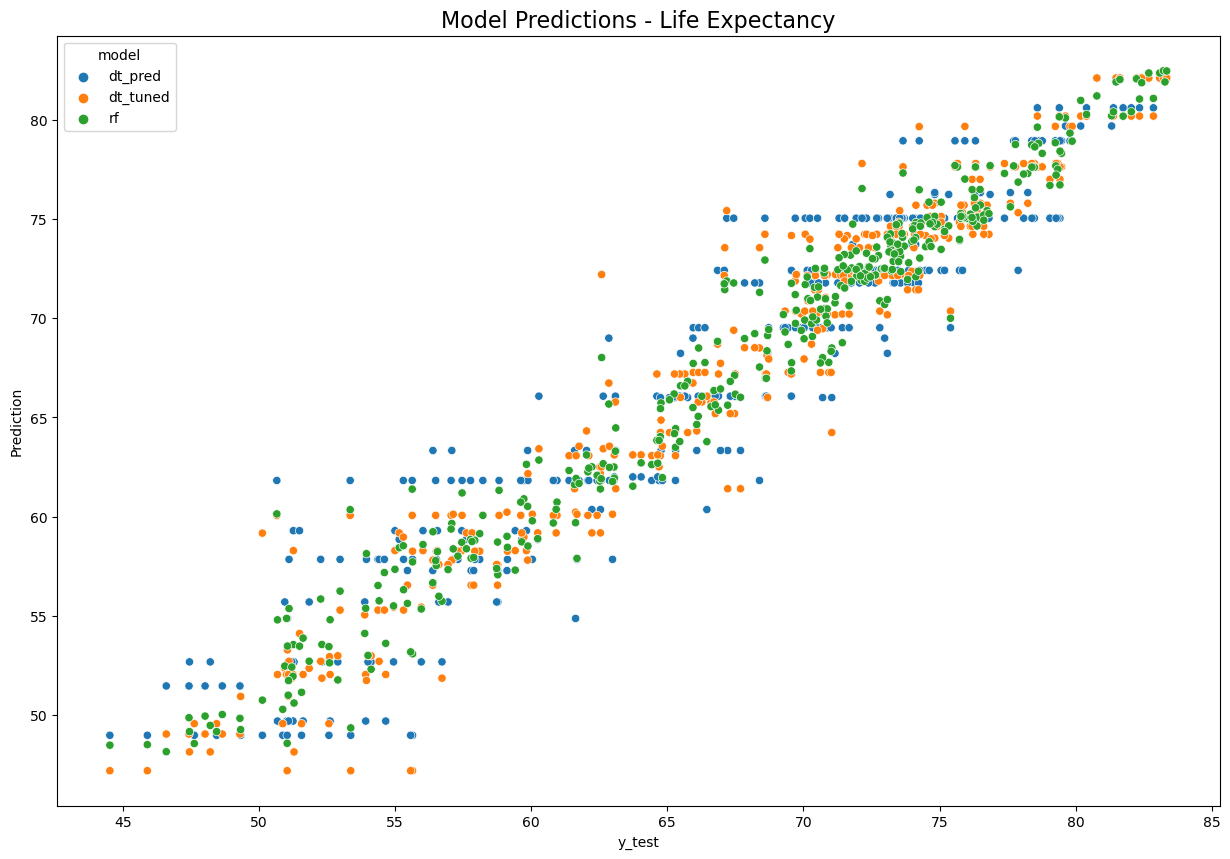

In [109]:
#Plotting Decision Tree and tuned Decision tree predictions v actual life expectancy
plt.figure(figsize=(15,10))
sns.scatterplot(dtrees_plotter2, x="y_test", y="Prediction", hue =  "model" )
plt.title("Model Predictions - Life Expectancy",
          fontsize=16)
plt.show()

The random forest scatter when compared to the decision trees deomstrates the a closer prediction of the actual life expectancy values.

<Axes: title={'center': 'Importances Comaprison'}>

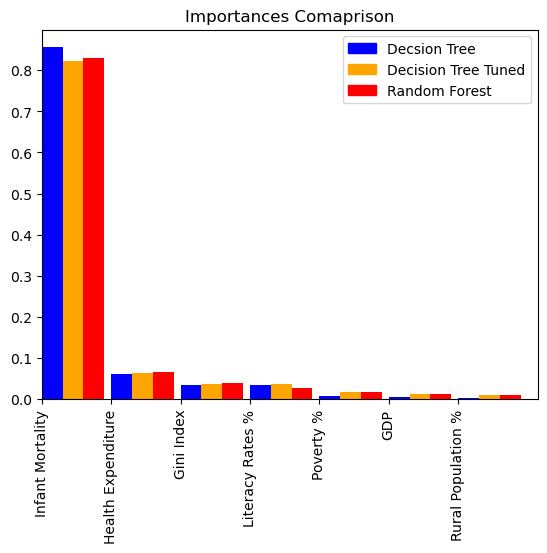

In [115]:
# Comparing Importances

importances_tree = decision_tree.feature_importances_
importances_tuned = decision_tree_tuned.feature_importances_
importances_rf = rf1.best_estimator_.feature_importances_

importances_tree = pd.Series(importances_tree, index=X.columns).sort_values(ascending=False)
importances_tuned = pd.Series(importances_tuned, index=X.columns).sort_values(ascending=False)
importances_rf = pd.Series(importances_rf, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
ax.set_title('Importances Comaprison')
colors = {'Decsion Tree':'blue', 'Decision Tree Tuned':'orange', "Random Forest": 'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
importances_tree.plot.bar(ax=ax, position = 0, width= 0.3, color ='blue')
importances_tuned.plot.bar(ax=ax, position = -1, width = 0.3, color ='orange')
importances_rf.plot.bar(ax=ax, position = -2, width = 0.3, color ='red')

In [111]:
#Final Results
final_results = pd.concat([decision_tree_scores, decision_tree_tuned_scores, rf1_scores])
#final_results

### Conculsions



Each iteration of the model marks an improvement on the previous. The initial decision tree is a good model due to the high r2 score, although the mean squared error value suggests ther may be overfitting.

The hyperparameter tuning of the decision tree improves all the model metrics, and the implementation of a random forest model produces the best results with the lowest mean squared error and highest r2 values.

In [112]:
final_results

,model,mean squared error,max error,r2
0,decision tree,7.974309,11.168054,0.905577
0,decision tree tuned,4.852321,9.623095,0.942544
0,random forest 1,2.929671,9.481615,0.965310


The importances comparision shows that the greatest infuenceer of Life Expectancy is infant mortality for all models with little variation.

It is likely possible to get a crude approximation of life expectancy with an OLS method using only infant mortality as this is the comfortably the dominiant predictor variable. This would use less computing power, however these results will be less accurate.

### Data Sources

Life Expectancy - https://data.worldbank.org/indicator/SP.DYN.LE00.IN

GDP - https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.CD&country#

Gini Index - https://data.worldbank.org/indicator/SI.POV.GINI

Poverty - https://data.worldbank.org/indicator/SI.POV.DDAY

Population - https://data.worldbank.org/indicator/SP.POP.TOTL

Health Expenditure - https://www.who.int/data/gho/data/indicators/indicator-details/GHO/current-health-expenditure-(che)-per-capita-in-us$

Rural Population - https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS

Literacy Rates - https://data.worldbank.org/indicator/SE.ADT.LITR.ZS

Infant Mortality - https://data.worldbank.org/indicator/SP.DYN.IMRT.IN